This code based implements a version of [Time2Vec: Learning a Vector Representation of Time](https://arxiv.org/pdf/1907.05321.pdf) and combines that with an LSTM model.

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from gc import collect
import pprint
from colorama import Fore, Style, init;
from warnings import filterwarnings;
filterwarnings('ignore');

In [36]:

def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    "Prints color outputs using colorama using a text F-string";
    print(style + color + text + Style.RESET_ALL); 

In [37]:
tf.random.set_seed(42)

In [38]:
# Imports
train = pd.read_csv(r'/kaggle/input/optiver-trading-at-the-close/train.csv')
test = pd.read_csv(r'/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv')
collect();

In [39]:
# We only need the targets from the training data as we are going to build a time series model for it.
train.sort_values(by=['stock_id', 'date_id', 'seconds_in_bucket'], inplace=True)
targets_df = pd.DataFrame(train[['stock_id', 'date_id', 'seconds_in_bucket', 'target']])
collect();

In [40]:
# We can also make a revealed targets dataframe (similar to in the test case)
# We get all the targets for the previous days, to ensure there is no leakage we enable a date access column so we can't access dates for the same day
unique_dates = test.date_id.unique()
revealed_targets_test = pd.DataFrame()
targets, dates, access_dates, stocks = [], [], [], []

for date in unique_dates:
    targets.append(train.loc[train.date_id == date]['target'])
    dates.append(train.loc[train.date_id == date - 1]['date_id'])
    access_dates.append(train.loc[train.date_id == date]['date_id'])
    stocks.append(train.loc[train.date_id == date]['stock_id'])

# flatten the n x 3 arrays so they can be added to the dataframe
    
revealed_targets_test['revealed_target'] = np.array(targets).flatten()
revealed_targets_test['date_id'] = np.array(dates).flatten()
revealed_targets_test['access_date_id'] = np.array(access_dates).flatten()
revealed_targets_test['stock_id'] = np.array(stocks).flatten()
collect();

## Multivariate Data Preprocessing
##### Previously in the univariate case the lstm was applied to a series *independent of the stock type*. In the this notebook the aim is to build a model that can capture the differences between the series of each stock and predict accordingly. This means the dataframe needs to be adjusted to reflect this, in the next section I will develop a method to split each stock into its own time series.

In [41]:
# changing the date to be multivariate where the features are stocks
def split_stocks(df, target_col='target'):
    y = pd.DataFrame()
    # iterate over each stock in the dataframe and assign them to a new df y
    for stock in df.stock_id.unique():
        y[f'stock_{stock}'] = df.loc[df.stock_id == stock][target_col]
    return y
collect();

In [42]:
# note we cannot run this as there are missing values for certain stocks
#y = split_stocks(targets_df)

In [43]:
%%time
# second method

# can we create a new dataframe that includes NaN values when a stock doesnt have a value for that date

# this method is quicker but still slow (any suggestions to improve this are welcome)
def rearrange_df(df, target_col='target'):
    # start by getting the unique values of each date, stock and seconds
    unique_dates = df.date_id.unique()
    unique_stocks = df.stock_id.unique()
    unique_seconds = df.seconds_in_bucket.unique()
    
    cols = list(unique_stocks)
    cols.append('date_id')
    cols.append('seconds_in_bucket')
    # init a df that values can be placed in
    d = pd.DataFrame([np.zeros(202)], columns=cols)
    
    for date in unique_dates:
        # get the values for the date_id == date
        date_df = df.loc[df.date_id == date]
        for seconds in unique_seconds:
            # get the values for the seconds_in_bucket == seconds at date_id == date
            seconds_df = date_df[date_df.seconds_in_bucket == seconds]

            # list of stock_ids that have values at this time point, to be used as columns for temp df
            columns = list(seconds_df.stock_id.values)
            columns.append('date_id')
            columns.append('seconds_in_bucket')

            # list of target values, date_id and seconds_in_bucket for the given time point
            values = list(seconds_df[target_col].values)
            values.append(date)
            values.append(seconds)

            # init df with these values and concat with first df
            seconds_df_new = pd.DataFrame([values], columns=columns)
            d = pd.concat([d, seconds_df_new], axis=0, ignore_index=True)

    return d

d = rearrange_df(targets_df)

# drop the row used in the initialisation
d.drop(0, axis=0, inplace=True)
print(d.head(3))
collect();

          0         1         2         3         4         5         6  \
1 -3.029704 -5.519986 -8.389950 -4.010200 -7.349849  6.779432 -2.499819   
2  0.389814 -1.620054 -7.460117 -1.040101 -6.719828  7.710457 -4.280209   
3  4.220009 -6.459951 -6.380081 -2.030134 -0.690222  1.009703  2.930164   

           7         8         9  ...        192       193       194  \
1  -1.959801 -5.970001  7.970333  ... -11.529922 -6.489754  3.999472   
2  -8.010268 -0.780225 -0.640154  ... -15.599728 -1.749992 -9.030104   
3 -12.069941 -4.119873 -3.250241  ... -12.710094  2.160072 -9.999871   

        195       196       197       198  199  date_id  seconds_in_bucket  
1 -0.690222 -0.810027 -8.440018 -0.510216  NaN      0.0                0.0  
2 -1.320243 -3.259778 -4.410148 -1.419783  NaN      0.0               10.0  
3  5.890131 -0.029802 -6.819964  2.599955  NaN      0.0               20.0  

[3 rows x 202 columns]
CPU times: user 6min 15s, sys: 197 ms, total: 6min 15s
Wall time: 6min 12s


### Investigating missing values
##### We already know there are missing values for stocks at specific timepoints, can we see whether they are distributed evenly or they are for one specific stock.

---Percentage of targets that are missing for each stock---


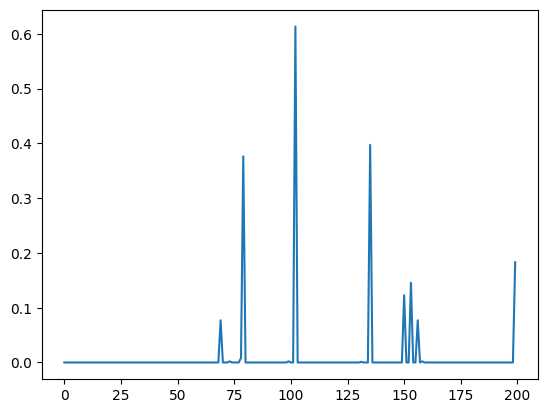

In [44]:
numerical_d = d.drop(['date_id', 'seconds_in_bucket'], axis=1)
PrintColor('---Percentage of targets that are missing for each stock---')
plt.plot(numerical_d.isna().sum() / len(numerical_d))
plt.show()
collect();

In [45]:
# for now just fill the missing values with 0s, in future use more complex ways to impute NaNs
numerical_d.fillna(0, inplace=True)

### Normalisation

In [46]:
scaler = MinMaxScaler(feature_range=(-1, 1))
# Normalise and fit the data (only to be used on the training set)
def normalise_and_fit(df):
    df = df.copy()
    df[df.columns] = scaler.fit_transform(df[df.columns])
    return df

# Just normalise the data, used in test and validation
def normalize_df(df):
    df = df.copy()
    df[df.columns] = scaler.transform(df[df.columns])
    return df

# different helper function for just 1D arrays
def normalize_1D_array(arr, n_samples=1, n_features=200):
    arr = scaler.transform(X.reshape(n_samples, n_features))
    return arr

In [47]:
normalised_numerical_df = normalise_and_fit(numerical_d)

### Training

In [48]:
# gets close to 60% train, 15% validation, 15% test
train, test_df = train_test_split(normalised_numerical_df, train_size = .85, random_state=42, shuffle=False)
train_df, val_df = train_test_split(train, train_size=12/17, random_state=42, shuffle=False)

In [49]:
length = 55
input_series_length = 55
output_series_length = 55
n_features = 200
batch_size = 55
n_samples = np.ceil(len(train) / batch_size)

In [50]:
# as seen in https://www.kaggle.com/code/nicapotato/keras-timeseries-multi-step-multi-output/notebook
def multivariate_multioutput_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
    
    return np.array(data), np.array(labels)

In [51]:
train_X, train_y = multivariate_multioutput_data(train_df.to_numpy(), train_df.to_numpy(), 0, None, input_series_length, output_series_length, 1)
val_X, val_y = multivariate_multioutput_data(val_df.to_numpy(), val_df.to_numpy(), 0, None, input_series_length, output_series_length, 1)
test_X, test_y = multivariate_multioutput_data(test_df.to_numpy(), test_df.to_numpy(), 0, None, input_series_length, output_series_length, 1)

In [52]:
print (train_X.shape,
       train_y.shape,
       val_X.shape,
       val_y.shape,
       'Single window of past history : {}'.format(train_X[0].shape),
       'Target window to predict : {}'.format(train_y[0].shape),
       sep='\n')

(15762, 55, 200)
(15762, 55, 200)
(6504, 55, 200)
(6504, 55, 200)
Single window of past history : (55, 200)
Target window to predict : (55, 200)


In [53]:
train_data_multi = tf.data.Dataset.from_tensor_slices((train_X, train_y))
train_data_multi = train_data_multi.batch(batch_size).repeat()

test_data_multi = tf.data.Dataset.from_tensor_slices((test_X))
test_data_multi = test_data_multi.batch(batch_size)

val_data_multi = tf.data.Dataset.from_tensor_slices((val_X, val_y))
val_data_multi = val_data_multi.batch(batch_size).repeat()
collect();

In [54]:
class Time2Vec(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(Time2Vec, self).__init__(**kwargs)

    def build(self, input_shape):
        _, self.sequence_length, self.n_features = input_shape

        self.W = self.add_weight(name='W',
                                shape=(self.sequence_length, self.n_features),
                                initializer='uniform',
                                trainable=True)

        self.P = self.add_weight(name='P',
                                shape=(self.sequence_length, self.n_features),
                                initializer='uniform',
                                trainable=True)

        super(Time2Vec, self).build(input_shape)

    def call(self, x):
        
        original =  x * self.W + self.P
        sin_trans = tf.sin(original[:,:-1,:])
        return tf.concat([sin_trans, original[:,-1,:][:,tf.newaxis,:]], axis=1)

In [55]:
# Add the Time2Vec layer (modify 'output_dim' as needed)
model = Sequential()

model.add(Time2Vec(output_dim=200, input_shape=(55, n_features)))

# Add the LSTM layer with return_sequences=True
model.add(LSTM(200, activation='tanh', return_sequences=True))

# Compile the model
model.compile(optimizer='adam', loss='mae', metrics=['mse', 'accuracy'])

# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time2_vec_1 (Time2Vec)      (None, 55, 200)           22000     
                                                                 
 lstm_1 (LSTM)               (None, 55, 200)           320800    
                                                                 
Total params: 342,800
Trainable params: 342,800
Non-trainable params: 0
_________________________________________________________________


In [56]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights=True)

In [57]:
# Model definition
# model = Sequential()
# model.add(LSTM(200, activation = 'tanh', input_shape=(train_X.shape[1], n_features), return_sequences=True))
# model.compile(optimizer='adam', loss='mae', metrics =['mse', 'accuracy'])
# model.summary()


In [58]:
history = model.fit(train_data_multi, validation_data=val_data_multi, steps_per_epoch = n_samples, validation_steps=n_samples, epochs=100, verbose=1, callbacks=[early_stopping]).history

Epoch 1/100
409/409 [==============================] - 83s 197ms/step - loss: 0.0834 - mse: 0.0142 - accuracy: 0.2985 - val_loss: 0.0822 - val_mse: 0.0133 - val_accuracy: 0.3079
Epoch 2/100
409/409 [==============================] - 99s 243ms/step - loss: 0.0834 - mse: 0.0140 - accuracy: 0.2845 - val_loss: 0.0817 - val_mse: 0.0132 - val_accuracy: 0.3079
Epoch 3/100
409/409 [==============================] - 80s 195ms/step - loss: 0.0778 - mse: 0.0124 - accuracy: 0.3225 - val_loss: 0.0816 - val_mse: 0.0131 - val_accuracy: 0.3079
Epoch 4/100
409/409 [==============================] - 79s 193ms/step - loss: 0.0843 - mse: 0.0144 - accuracy: 0.2814 - val_loss: 0.0819 - val_mse: 0.0132 - val_accuracy: 0.3079
Epoch 5/100
409/409 [==============================] - 79s 194ms/step - loss: 0.0791 - mse: 0.0127 - accuracy: 0.3140 - val_loss: 0.0814 - val_mse: 0.0131 - val_accuracy: 0.3079
Epoch 6/100
409/409 [==============================] - 99s 241ms/step - loss: 0.0820 - mse: 0.0138 - accuracy:

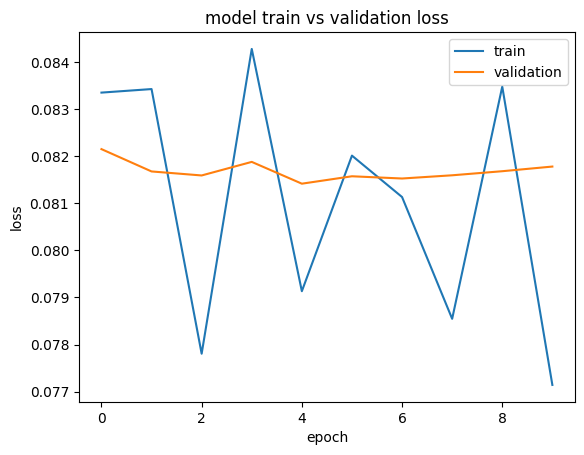

In [59]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Making Predictions

In [60]:
predictions = model.predict(test_X)
scaled_pred = scaler.inverse_transform(predictions.reshape(predictions.shape[0] * predictions.shape[1], predictions.shape[2]))
scaled_true = scaler.inverse_transform(test_y.reshape(predictions.shape[0] * predictions.shape[1], predictions.shape[2]))

121/121 [==============================] - 5s 41ms/step


In [61]:
PrintColor(f'MAE on normalised test data: {mae(test_y.flatten(), predictions.flatten())}')
PrintColor(f'MAE on test data: {mae(scaled_true, scaled_pred)}')

MAE on normalised test data: 0.07372929950017815
MAE on test data: 5.888265145670394


### Using the Optiver Environment

<Axes: >

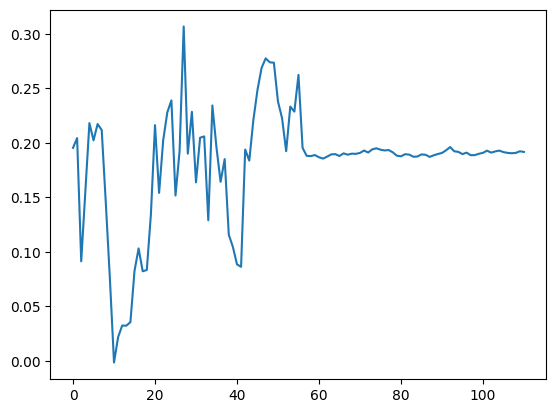

In [84]:
normalised_history[0].plot()

In [85]:
from sklearn.metrics import precision_score

# Calculate precision with 'macro' average
precision = precision_score(np.round(test_y.flatten()), np.round(predictions.flatten()), average='macro')

# Print the result
print(f'Precision (macro): {precision}')
from sklearn.metrics import accuracy_score

# Flatten and round the true and predicted labels if necessary
true_labels = np.round(test_y.flatten())
predicted_labels = np.round(predictions.flatten())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Print the accuracy
print(f'Accuracy: {accuracy}')



Precision (macro): 0.6553991623067832
Accuracy: 0.9863566632900658
